In [1]:
#Road defects classification - Rutting, Pothole, Patch, Crack, Raveling
#Author: Tasmia Azim, Nayeem Khan


In [2]:
import zipfile
import os

images_folder = "/kaggle/input/road-defects-merged/Road Defects/Images"
labels_file = "/kaggle/input/road-defects-merged/Road Defects/Label_Unified_V8.csv"
output_folder="Reports"

In [3]:
import pandas as pd

columns = ["image_name", "labels"]

# Load the CSV with defined column names
labels_df = pd.read_csv(labels_file, names=columns, header=None)
labels_df["labels"] = labels_df["labels"].str.lower()

print(labels_df.head())

               image_name                                   labels
0  020CE336717 0001_part2                                    patch
1  020CE336717 0001_part3   isolated_crack patch sidewalk_shoulder
2  020CE336717 0002_part2                     isolated_crack patch
3  020CE336717 0002_part3   isolated_crack patch sidewalk_shoulder
4  020CE336717 0004_part2        bleeding patch depression_rutting


In [4]:
import os
import pandas as pd

def export_label_distribution(labels_df, output_folder="Reports", output_file="label_distribution.csv"):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Split the labels into individual labels and calculate distribution
    all_labels = labels_df["labels"].str.split().explode()
    label_distribution = all_labels.value_counts().reset_index()
    label_distribution.columns = ["label", "count"]

    # Export to CSV
    output_path = os.path.join(output_folder, output_file)
    label_distribution.to_csv(output_path, index=False)

    print(f"Label distribution exported to {output_path}")

# Example usage
labels_file = "label_distribution.csv"


# Export the label distribution
export_label_distribution(labels_df)


Label distribution exported to Reports/label_distribution.csv


In [5]:
from torchvision import transforms
from sklearn.preprocessing import MultiLabelBinarizer
import torch
from PIL import Image

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


labels_list = labels_df.iloc[:, 1].apply(lambda x: x.strip().split(" ")).tolist()

mlb = MultiLabelBinarizer()
labels_binary = mlb.fit_transform(labels_list)

print("Labels binary matrix shape:", labels_binary.shape)
print("Example binary labels for first image:", labels_binary[0])


Labels binary matrix shape: (12830, 11)
Example binary labels for first image: [0 0 0 0 0 0 0 1 0 0 0]


In [6]:
from torch.utils.data import Dataset

class RoadDefectDataset(Dataset):
    def __init__(self, images_folder, labels_df, labels_binary, transform=None):
        self.images_folder = images_folder
        self.labels_df = labels_df
        self.labels_binary = labels_binary
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        # Get image path and label
        img_name = f"{self.labels_df.iloc[idx, 0]}.jpg"  # Add .jpg extension
        img_path = os.path.join(self.images_folder, img_name)
        label = self.labels_binary[idx]

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# Create the dataset
dataset = RoadDefectDataset(images_folder, labels_df, labels_binary, transform=transform)

# Check a sample
sample_image, sample_label = dataset[0]
print(f"Sample image shape: {sample_image.shape}, Sample label: {sample_label}")


Sample image shape: torch.Size([3, 224, 224]), Sample label: tensor([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


In [7]:
from sklearn.model_selection import train_test_split

# Split dataset indices
train_indices, val_test_indices = train_test_split(range(len(labels_df)), test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_test_indices, test_size=0.5, random_state=42)

print(f"Train size: {len(train_indices)}, Val size: {len(val_indices)}, Test size: {len(test_indices)}")


Train size: 10264, Val size: 1283, Test size: 1283


In [8]:
from torchvision import transforms

# Define transformations for training and validation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [9]:
from torch.utils.data import DataLoader

train_dataset = RoadDefectDataset(images_folder, labels_df.iloc[train_indices], labels_binary[train_indices], transform=train_transforms)
val_dataset = RoadDefectDataset(images_folder, labels_df.iloc[val_indices], labels_binary[val_indices], transform=val_transforms)
test_dataset = RoadDefectDataset(images_folder, labels_df.iloc[test_indices], labels_binary[test_indices], transform=val_transforms)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [10]:
from torchvision.models import resnet50
import torch.nn as nn

# Load ResNet-50 model
base_model = resnet50(pretrained=True)

# Freeze feature extractor layers
for param in base_model.parameters():
    param.requires_grad = False

unique_labels = sorted(set(label for sublist in labels_list for label in sublist))

num_classes = len(unique_labels)
base_model.fc = nn.Sequential(
    nn.Linear(base_model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, num_classes),
    nn.Sigmoid()
)

print("Model architecture updated for multi-label classification:")
print(base_model)
print(unique_labels)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]


Model architecture updated for multi-label classification:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
 

In [11]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 8.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [12]:
import os
from docx import Document

def export_model_details_to_doc(model, output_folder="Reports", output_file="model_details.docx"):
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Create a Word document
    document = Document()
    document.add_heading("Model Architecture Details", level=1)

    # Add the model's architecture details
    document.add_paragraph("The following details represent the architecture of the model:\n")
    document.add_paragraph(str(model))

    # Save the document
    output_path = os.path.join(output_folder, output_file)
    document.save(output_path)

    print(f"Model details exported to {output_path}")

# Export the model details
export_model_details_to_doc(base_model)


Model details exported to Reports/model_details.docx


In [13]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(base_model.fc.parameters(), lr=1e-3)


In [14]:
import torch
from torch.utils.data import DataLoader
import time

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    # Move model to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': []}
    epoch_details = []
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        total_train = 0

        # Training phase
        start_time = time.time()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predictions = (outputs > 0.5).float()  # Apply threshold of 0.5 for multi-label classification
            train_correct += (predictions == labels).sum().item()
            total_train += labels.numel()


        train_loss /= len(train_loader)
        train_accuracy = train_correct / total_train * 100

        model.eval()
        val_loss = 0.0
        val_correct = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)

                # Compute loss
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Track accuracy
                predictions = (outputs > 0.5).float()
                val_correct += (predictions == labels).sum().item()
                total_val += labels.numel()

        # Calculate validation accuracy and loss
        val_loss /= len(val_loader)
        val_accuracy = val_correct / total_val * 100

        # Save metrics for plotting
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)

        # Print results for this epoch
        epoch_time = time.time() - start_time
        epoch_summary = (
                f"Epoch {epoch + 1}/{num_epochs} | "
                f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.2f}% | "
                f"Val Loss: {val_loss:.4f} | Val Accuracy: {val_accuracy:.2f}% | "
                f"Time: {epoch_time:.2f}s\n"
            )
        print(epoch_summary)
        epoch_details.append(epoch_summary)
        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print("Best model saved!")
    return epoch_details, history    
# Start training
epoch_details, history = train_model(base_model, train_loader, val_loader, criterion, optimizer, num_epochs=10)


Epoch 1/10 | Train Loss: 0.2731 | Train Accuracy: 88.58% | Val Loss: 0.2238 | Val Accuracy: 90.36% | Time: 156.85s

Best model saved!
Epoch 2/10 | Train Loss: 0.2381 | Train Accuracy: 90.03% | Val Loss: 0.2178 | Val Accuracy: 90.90% | Time: 61.31s

Best model saved!
Epoch 3/10 | Train Loss: 0.2312 | Train Accuracy: 90.34% | Val Loss: 0.2060 | Val Accuracy: 91.53% | Time: 60.84s

Best model saved!
Epoch 4/10 | Train Loss: 0.2263 | Train Accuracy: 90.58% | Val Loss: 0.2010 | Val Accuracy: 91.75% | Time: 60.89s

Best model saved!
Epoch 5/10 | Train Loss: 0.2235 | Train Accuracy: 90.66% | Val Loss: 0.1986 | Val Accuracy: 91.84% | Time: 61.41s

Best model saved!
Epoch 6/10 | Train Loss: 0.2184 | Train Accuracy: 90.91% | Val Loss: 0.1959 | Val Accuracy: 92.01% | Time: 58.26s

Best model saved!
Epoch 7/10 | Train Loss: 0.2175 | Train Accuracy: 91.02% | Val Loss: 0.1937 | Val Accuracy: 91.99% | Time: 56.58s

Best model saved!
Epoch 8/10 | Train Loss: 0.2160 | Train Accuracy: 91.05% | Val Loss:

In [15]:
def export_epoch_details_to_csv(epoch_details, output_folder="Reports", output_file="epoch_details.csv"):
    import os
    import csv
    
    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)
    
    # Define headers
    headers = ["Epoch", "Train Loss", "Train Accuracy (%)", "Val Loss", "Val Accuracy (%)", "Time (s)"]

    # Parse epoch details
    parsed_details = []
    for detail in epoch_details:
        try:
            parts = [part.strip() for part in detail.split("|")]
            epoch_data = []
            for part in parts:
                if ":" in part:
                    epoch_data.append(part.split(":")[1].strip())
                else:
                    epoch_data.append(part.strip())  # In case the part does not follow the "key: value" format
            parsed_details.append(epoch_data)
        except Exception as e:
            print(f"Error parsing detail: {detail}. Error: {e}")

    # Export to CSV
    output_path = os.path.join(output_folder, output_file)
    with open(output_path, mode="w", newline="") as f:
        writer = csv.writer(f)
        writer.writerow(headers)  # Write headers
        writer.writerows(parsed_details)  # Write epoch data
    
    print(f"Epoch details exported to {output_path}")

export_epoch_details_to_csv(epoch_details)


Epoch details exported to Reports/epoch_details.csv


In [16]:
def test_model(model, test_loader):
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    test_loss = 0.0
    test_correct = 0
    total_test = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Track accuracy
            predictions = (outputs > 0.5).float()
            test_correct += (predictions == labels).sum().item()
            total_test += labels.numel()

    # Calculate test accuracy and loss
    test_loss /= len(test_loader)
    test_accuracy = test_correct / total_test * 100

    print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.2f}%")
# After training, test the model
test_model(base_model, test_loader)

/tmp/ipykernel_23/3893996666.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 0.1936 | Test Accuracy: 92.59%


Evaluation history exported to Reports/evaluation_history.png


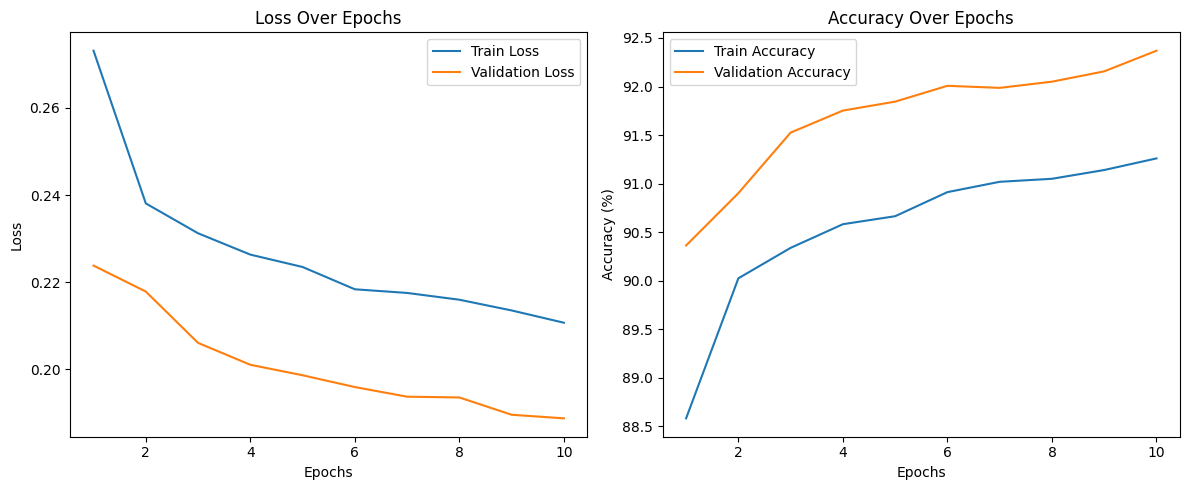

In [17]:
import matplotlib.pyplot as plt

def plot_history(history, folder_path="Reports", save_plots = True):
    epochs = range(1, len(history['train_loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_accuracy'], label='Train Accuracy')
    plt.plot(epochs, history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    # Save the confusion matrix if required
    if save_plots:
        save_path = os.path.join(folder_path, "evaluation_history.png")
        plt.savefig(save_path)
        print(f"Evaluation history exported to {save_path}")
    plt.tight_layout()
    plt.show()
    

# Plot the history
plot_history(history, folder_path="Reports", save_plots = True)


/tmp/ipykernel_23/3504143106.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


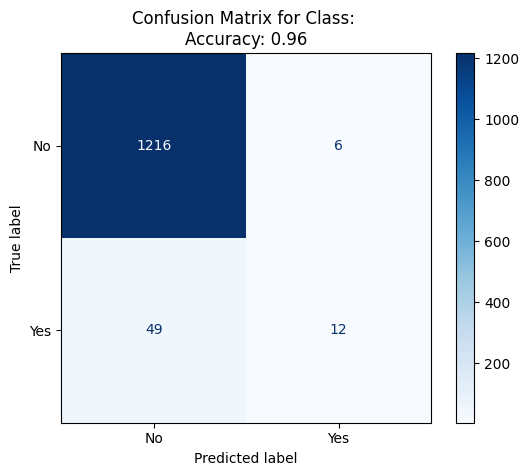

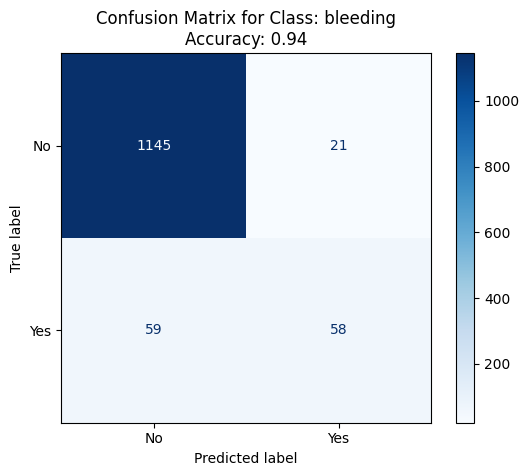

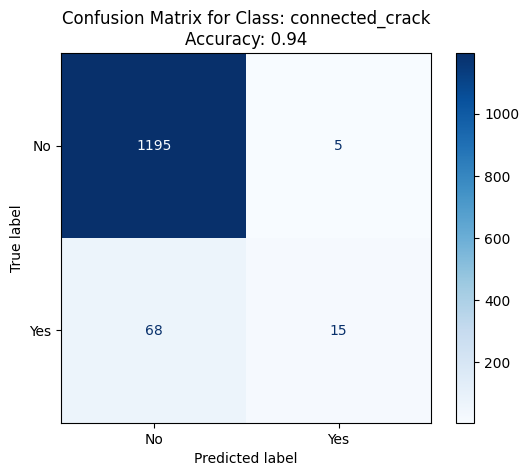

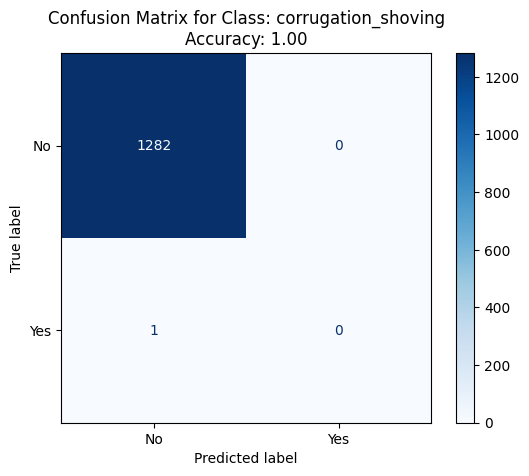

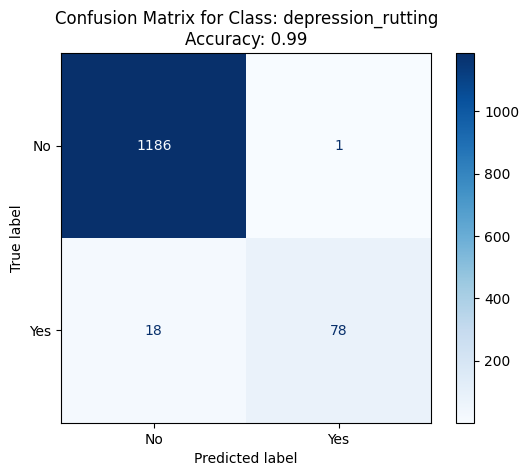

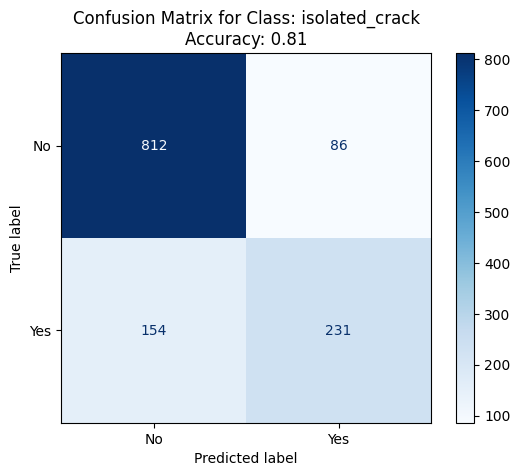

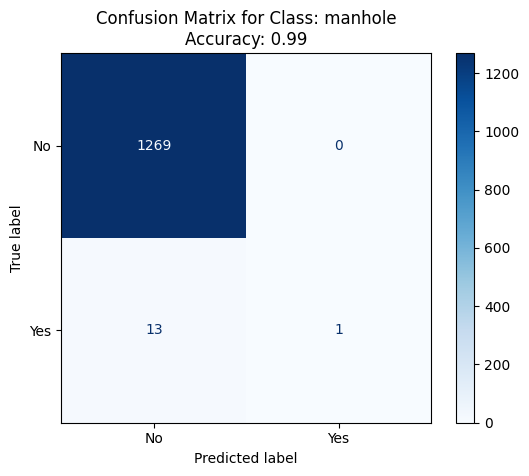

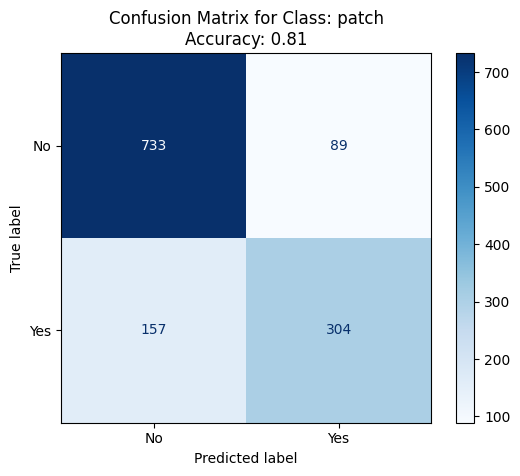

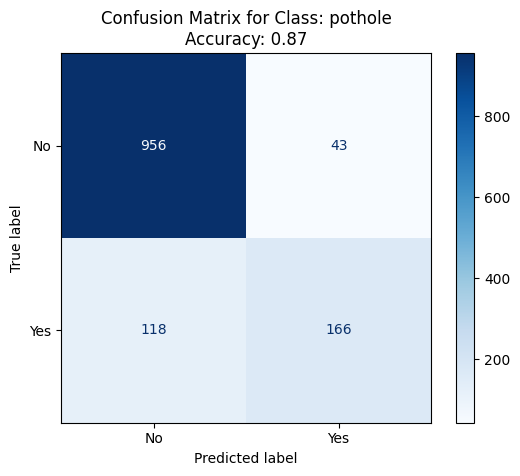

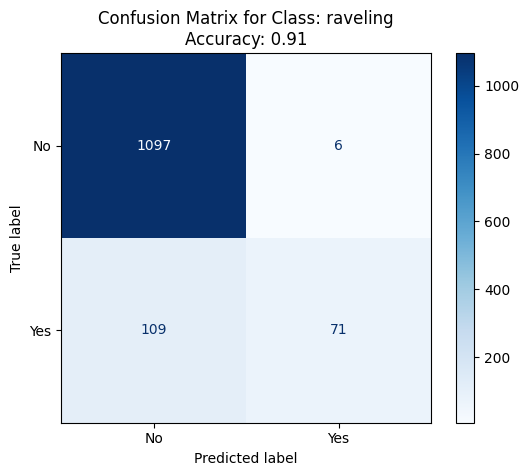

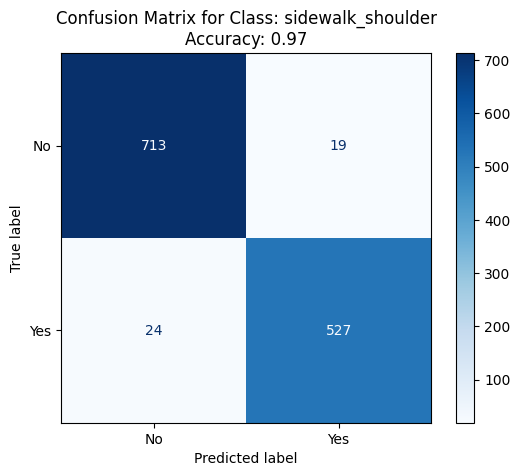

In [18]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import os

def save_confusion_matrix(cm, class_name, folder_path="Reports"):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for Class: {class_name}")

    # Save the plot
    save_path = os.path.join(folder_path, f"confusion_matrix_{class_name}.png")
    plt.savefig(save_path)
    plt.close()

def plot_confusion_matrices(model, test_loader, class_names, save_plots=False):
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect predictions and ground truth
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Calculate confusion matrix for each class
    for i, class_name in enumerate(class_names):
        y_true = all_labels[:, i]
        y_pred = all_preds[:, i]

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        accuracy = accuracy_score(y_true, y_pred)
        # Display confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for Class: {class_name}\nAccuracy: {accuracy:.2f}")
        plt.show()

        # Save the confusion matrix if required
        if save_plots:
            save_confusion_matrix(cm, class_name)

# Define class names (unique_labels should be defined in your script)
class_names = unique_labels

# Call the function to plot and save confusion matrices
plot_confusion_matrices(base_model, test_loader, class_names, save_plots=True)


In [19]:
import os
import csv

def export_class_accuracies_to_csv(model, class_names, folder_path="Reports", file_name="class_accuracies.csv"):
    # Ensure the folder exists
    os.makedirs(folder_path, exist_ok=True)
    # Load the best model
    model.load_state_dict(torch.load("best_model.pth"))
    model.eval()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Collect predictions and ground truth
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            predictions = (outputs > 0.5).float()

            all_labels.append(labels.cpu().numpy())
            all_preds.append(predictions.cpu().numpy())

    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    class_accuracies = []  # Store class-wise accuracy

    # Calculate accuracy for each class
    for i, class_name in enumerate(class_names):
        y_true = all_labels[:, i]
        y_pred = all_preds[:, i]
        accuracy = accuracy_score(y_true, y_pred)
        class_accuracies.append(accuracy)

    # Prepare the CSV file path
    file_path = os.path.join(folder_path, file_name)

    # Write class accuracies to the CSV file
    with open(file_path, mode="w", newline="") as file:
        writer = csv.writer(file)
        # Write header
        writer.writerow(["Class Name", "Accuracy"])
        # Write data
        for class_name, accuracy in zip(class_names, class_accuracies):
            accuracy_percentage = accuracy * 100  # Convert to percentage
            writer.writerow([class_name, f"{accuracy_percentage:.2f}%"])

    print(f"Class accuracies exported to {file_path}")

# Export to CSV
export_class_accuracies_to_csv(base_model, class_names)


/tmp/ipykernel_23/2378682264.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Class accuracies exported to Reports/class_accuracies.csv


In [20]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def predict_image(model, image_path, class_names):
    # Load and preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension

    # Move to device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)
    model.to(device)

    # Set model to evaluation mode
    model.eval()

    with torch.no_grad():
        output = model(input_tensor)
        predictions = (output > 0.5).float().cpu().numpy().flatten()

    # Map predictions to class names
    predicted_classes = [class_names[i] for i, pred in enumerate(predictions) if pred == 1]
    return predicted_classes, image


In [22]:
def predict_specific_images_in_folder(model, folder_path, predict_images, class_names):
    for image_name in predict_images:
        image_path = os.path.join(folder_path, image_name)
        if image_name.lower().endswith(('png', 'jpg', 'jpeg')):
            predicted_classes, img = predict_image(model, image_path, class_names)
            print(f"Image: {image_name} | Predicted Classes: {predicted_classes}")
class_names = unique_labels
folder_path = "/kaggle/input/road-defects-merged/Road Defects/Images"
predict_images = ["020CE336717 0004_part2.jpg", 
              "020CE336717 0004_part3.jpg",
              "138ECE0070S0_Frontal 622_part3.jpg",
              "138ECE0110S0_Frontal 1181_part3.jpg"]
predict_specific_images_in_folder(base_model, folder_path, predict_images, class_names)            


Image: 020CE336717 0004_part2.jpg | Predicted Classes: ['bleeding', 'sidewalk_shoulder']
Image: 020CE336717 0004_part3.jpg | Predicted Classes: ['bleeding', 'sidewalk_shoulder']
Image: 138ECE0070S0_Frontal 622_part3.jpg | Predicted Classes: ['patch', 'sidewalk_shoulder']
Image: 138ECE0110S0_Frontal 1181_part3.jpg | Predicted Classes: ['pothole', 'sidewalk_shoulder']
